In [1]:
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.datasets import load_iris, load_wine
import sklearn.metrics as metrics

import warnings
warnings.simplefilter('ignore')

import matplotlib
matplotlib.rcParams["font.family"]="Malgun Gothic"
matplotlib.rcParams["axes.unicode_minus"]= False

import requests
from xml.etree import ElementTree 

### 데이터 가져오기

In [2]:
url = 'https://www.weather.go.kr/weather/forecast/mid-term-rss3.jsp?stnId=109'
response = requests.get(url)

#파싱
tree = ElementTree.fromstring(response.content)
elements = tree.iter("location")

df = []
for el in elements:
    city = el.find("city").text
    for data in el.iter('data'):
        tmEf = data.find('tmEf').text
        wf = data.find('wf').text
        tmn = data.find('tmn').text
        tmx = data.find('tmx').text
        
        df.append([city,tmEf,wf,tmn,tmx])
df = pd.DataFrame(df, columns =['city','tmEf','wf','tmn','tmx'])
display(df.head())

,city,tmEf,wf,tmn,tmx
0,서울,2021-07-28 00:00,맑음,26,35
1,서울,2021-07-28 12:00,맑음,26,35
2,서울,2021-07-29 00:00,맑음,25,34
3,서울,2021-07-29 12:00,구름많음,25,34
4,서울,2021-07-30 00:00,구름많음,26,34


---
### 데이터 전처리

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   city    455 non-null    object
 1   tmEf    455 non-null    object
 2   wf      455 non-null    object
 3   tmn     455 non-null    object
 4   tmx     455 non-null    object
dtypes: object(5)
memory usage: 17.9+ KB


In [4]:
#온도 컬럼의 자료형 변경
df[['tmn','tmx']] = df[['tmn','tmx']].astype(np.float32)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    455 non-null    object 
 1   tmEf    455 non-null    object 
 2   wf      455 non-null    object 
 3   tmn     455 non-null    float32
 4   tmx     455 non-null    float32
dtypes: float32(2), object(3)
memory usage: 14.3+ KB


In [5]:
#target 만들기
df[['target_tmn','target_tmx']] = df[['tmn','tmx']].shift(-1)
df.head()

,city,tmEf,wf,tmn,tmx,target_tmn,target_tmx
0,서울,2021-07-28 00:00,맑음,26.0,35.0,26.0,35.0
1,서울,2021-07-28 12:00,맑음,26.0,35.0,25.0,34.0
2,서울,2021-07-29 00:00,맑음,25.0,34.0,25.0,34.0
3,서울,2021-07-29 12:00,구름많음,25.0,34.0,26.0,34.0
4,서울,2021-07-30 00:00,구름많음,26.0,34.0,26.0,34.0


In [6]:
#각 지역별 마지막 행은 의미가 없으므로 삭제
lst = [i % 13 != 12 for i in range(len(df))]
df = df[lst]
df.reset_index(drop = True,inplace = True)
display(df[df['city'] == '서울'].tail())
display(df[df['city'] == '여주'].tail())

,city,tmEf,wf,tmn,tmx,target_tmn,target_tmx
7,서울,2021-07-31 12:00,구름많음,26.0,35.0,26.0,34.0
8,서울,2021-08-01 00:00,구름많음,26.0,34.0,26.0,34.0
9,서울,2021-08-01 12:00,구름많음,26.0,34.0,26.0,34.0
10,서울,2021-08-02 00:00,구름많음,26.0,34.0,26.0,34.0
11,서울,2021-08-03 00:00,맑음,26.0,34.0,26.0,34.0


,city,tmEf,wf,tmn,tmx,target_tmn,target_tmx
415,여주,2021-07-31 12:00,구름많음,24.0,33.0,24.0,31.0
416,여주,2021-08-01 00:00,구름많음,24.0,31.0,24.0,31.0
417,여주,2021-08-01 12:00,구름많음,24.0,31.0,23.0,32.0
418,여주,2021-08-02 00:00,구름많음,23.0,32.0,23.0,32.0
419,여주,2021-08-03 00:00,맑음,23.0,32.0,24.0,32.0


In [7]:
x_data = df[['city','tmn','tmx']]
y_data = df[['target_tmn','target_tmx']]

In [8]:
#원핫 인코딩
# x_data = pd.get_dummies(x_data,columns=['city'])
onehot = OneHotEncoder(sparse = False)
city_onehot = onehot.fit_transform(x_data[['city']])
#onehot 데이터를 df로
city_onehot = pd.DataFrame(data = city_onehot, columns=onehot.get_feature_names(['city']))
x_data = pd.concat([x_data, city_onehot], axis =1 ).drop(['city'], axis = 1)

---
### 모델

In [9]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 2020)

model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [10]:
#점수 확인
print(model.score(x_train,y_train))
print(model.score(x_test,y_test))

0.8570383435859907
0.7836722818778108


# 예측해보기

서울, 2021-08-01 00:00, 구름많음, 26.0, 34.0 / 답:26.0, 33.0  
여주, 2021-08-01 00:00, 구름많음, 23.0, 32.0 / 답:23.0, 33.0

In [11]:
test = pd.DataFrame([['서울',23.0, 32.0],['여주',23.0,32.0,]], columns = ['city','tmn','tmx'])

In [12]:
#test data 
test_onehot = onehot.transform(test[['city']])
test_onehot = pd.DataFrame(data = test_onehot, columns=onehot.get_feature_names(['city']))
test = pd.concat([test, test_onehot], axis =1 ).drop(['city'], axis = 1)
test

,tmn,tmx,city_가평,city_강화,city_고양,city_과천,city_광명,city_광주,city_구리,city_군포,...,city_용인,city_의왕,city_의정부,city_이천,city_인천,city_파주,city_평택,city_포천,city_하남,city_화성
0,23.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
predict =  model.predict(test)
print('서울 : ' , predict[0])
print('여주 : ' , predict[1])

서울 :  [24.22214219 33.47590524]
여주 :  [23.30612656 32.02473337]


---
### 일교차 구하기

In [14]:
df['tmn'] = df['tmn']
df['tmx'] = df['tmx']
df['daily_diff'] = df['tmx'] - df['tmn']
df.sort_values('daily_diff', ascending=False)
df.head()

,city,tmEf,wf,tmn,tmx,target_tmn,target_tmx,daily_diff
0,서울,2021-07-28 00:00,맑음,26.0,35.0,26.0,35.0,9.0
1,서울,2021-07-28 12:00,맑음,26.0,35.0,25.0,34.0,9.0
2,서울,2021-07-29 00:00,맑음,25.0,34.0,25.0,34.0,9.0
3,서울,2021-07-29 12:00,구름많음,25.0,34.0,26.0,34.0,9.0
4,서울,2021-07-30 00:00,구름많음,26.0,34.0,26.0,34.0,8.0


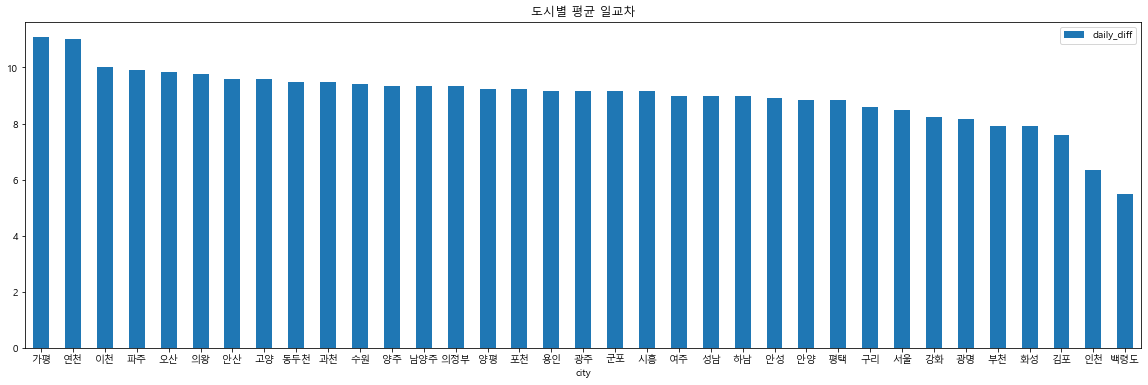

In [15]:
#도시별 평균일교차

df.groupby('city')[['daily_diff']].mean().sort_values(by= 'daily_diff', ascending = False).plot.bar(figsize = (20,6))
plt.title('도시별 평균 일교차')
plt.xticks(rotation = 0)
plt.show()

### 시계열 데이터 그려보기

In [16]:
df_time_index = df.drop(['target_tmn','target_tmx'], axis = 1)
df_time_index.index = pd.to_datetime(df['tmEf'])
df_time_index.head()

,city,tmEf,wf,tmn,tmx,daily_diff
tmEf,,,,,,
2021-07-28 00:00:00,서울,2021-07-28 00:00,맑음,26.0,35.0,9.0
2021-07-28 12:00:00,서울,2021-07-28 12:00,맑음,26.0,35.0,9.0
2021-07-29 00:00:00,서울,2021-07-29 00:00,맑음,25.0,34.0,9.0
2021-07-29 12:00:00,서울,2021-07-29 12:00,구름많음,25.0,34.0,9.0
2021-07-30 00:00:00,서울,2021-07-30 00:00,구름많음,26.0,34.0,8.0


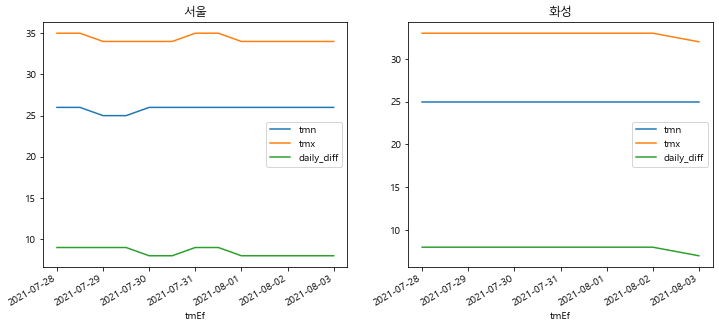

In [17]:
#서울과 화성의 온도 그래프

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('서울')
ax[1].set_title('화성')
df_time_index[df_time_index['city'] == '서울'].plot(ax = ax[0])
df_time_index[df_time_index['city'] == '화성'].plot(ax = ax[1])
plt.show()

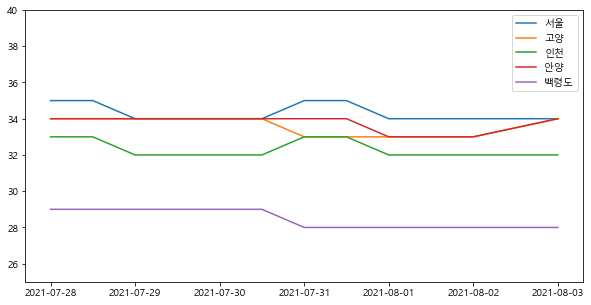

In [18]:
# 5개 지역 최고기온 그래프
cites = ['서울','고양','인천','안양','백령도']
plt.figure(figsize = (10, 5))
for city in cites:
    plt.plot(df_time_index[df_time_index['city'] == city]['tmx'])
plt.legend(cites)
plt.ylim([25, 40])
plt.show()

### 서울 시계열 그래프에 예측선 추가

In [19]:
# 서울의 최고기온 예측선 그리기
pred_line = pd.DataFrame(model.predict(x_data[x_data['city_서울'] == 1]), columns = ['tmEf', 'tmx'])
pred_line['tmEf'] = df[df['city'] == '서울']['tmEf']
pred_line.index = pd.to_datetime(pred_line['tmEf'])

In [20]:
pred_line

,tmEf,tmx
tmEf,,
2021-07-28 00:00:00,2021-07-28 00:00,34.653628
2021-07-28 12:00:00,2021-07-28 12:00,34.653628
2021-07-29 00:00:00,2021-07-29 00:00,34.261050
2021-07-29 12:00:00,2021-07-29 12:00,34.261050
2021-07-30 00:00:00,2021-07-30 00:00,34.175113
2021-07-30 12:00:00,2021-07-30 12:00,34.175113
2021-07-31 00:00:00,2021-07-31 00:00,34.653628
2021-07-31 12:00:00,2021-07-31 12:00,34.653628
2021-08-01 00:00:00,2021-08-01 00:00,34.175113


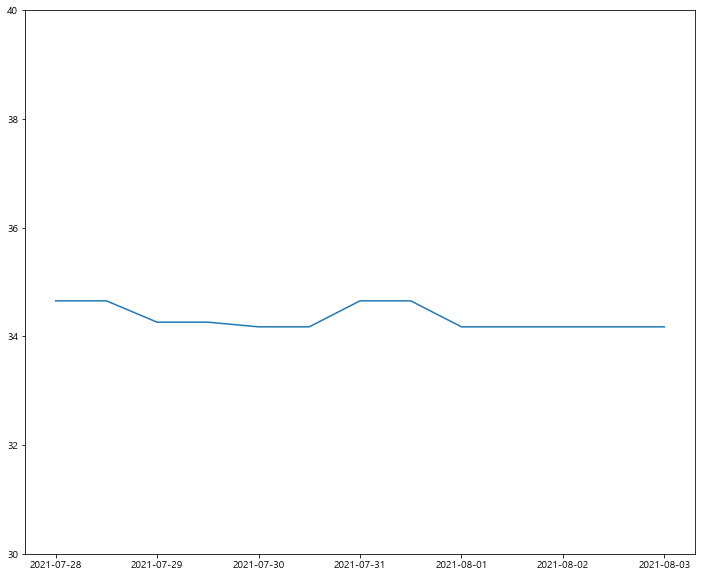

In [28]:
plt.figure(figsize = (12, 10))
plt.plot(pred_line['tmx'])
plt.ylim([30, 40])
plt.show()

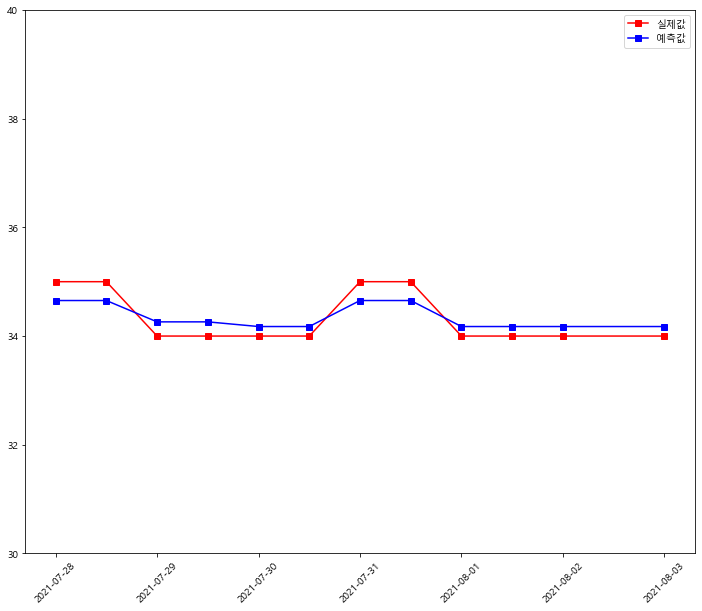

In [27]:
# 기존 데이터 선과 함께 보기
plt.figure(figsize = (12, 10))
plt.plot(df_time_index[df_time_index['city'] == '서울']['tmx'], 'rs-', label='실제값')
plt.plot(pred_line['tmx'], 'bs-', label='예측값')
plt.legend()
plt.xticks(rotation = 45)
plt.ylim([30, 40])
plt.show()

### 최고기온 최빈값, 누적합계, 백분율 

In [23]:
#최고기온 sidetable
!pip install sidetable
import sidetable 
df.stb.freq(['tmx'], style=True)

,tmx,count,percent,cumulative_count,cumulative_percent
0,33.000000,174,41.43%,174,41.43%
1,34.000000,145,34.52%,319,75.95%
2,32.000000,63,15.00%,382,90.95%
3,35.000000,22,5.24%,404,96.19%
4,29.000000,6,1.43%,410,97.62%
5,28.000000,6,1.43%,416,99.05%
6,31.000000,2,0.48%,418,99.52%
7,30.000000,2,0.48%,420,100.00%


### 도시별 최고기온 산점도

In [24]:
!pip install plotly_express
import plotly.express as px

In [25]:
fig = px.scatter(df, x="tmx", y="city", color="tmEf",
        labels=dict(tmx="최고 기온", city="지역", tmEf="날짜"))
fig.show()